In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns
import random

In [29]:
np.random.seed(44)
random.seed(44)

In [30]:

class NeuralNetwork4:

    def __init__(self, layer_sizes, activation='sigmoid', output_activation='linear', init_method='normal',classification=True, bias_sd = 0.01):
        """
        Inicjalizuje sieć neuronową MLP.

        :param layer_sizes: Lista określająca liczbę neuronów w kolejnych warstwach, np. [1, 5, 1]
        :param activation: Funkcja aktywacji dla warstw ukrytych (domyślnie 'sigmoid')
        :param output_activation: Funkcja aktywacji dla warstwy wyjściowej (domyślnie 'linear')
        :param init_method: Metoda inicjalizacji wag, opcje:
                            'normal'  - N(0,1) (domyślnie),
                            'uniform' - U[0,1],
                            'he'      - inicjalizacja He,
                            'xavier'  - inicjalizacja Xavier.
                            W przypadku nieznanej metody używana jest inicjalizacja normalna.
        """
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.init_method = init_method
        self.classification = classification
        self.gradient_history = []

        # Inicjalizacja parametrów (wag i biasów) dla każdej warstwy poza wejściową
        self.params = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i+1]

            if init_method == 'normal':
                # Domyślna inicjalizacja: N(0,1)
                W = np.random.randn(n_out, n_in)
                b = np.random.randn(n_out, 1) * bias_sd
            elif init_method == 'uniform':
                # Inicjalizacja z U[0,1]
                W = np.random.rand(n_out, n_in)
                b = np.random.rand(n_out, 1) * bias_sd
            elif init_method == 'he':
                # Inicjalizacja He: dla warstw z ReLU lub jej wariantami
                W = np.random.randn(n_out, n_in) * np.sqrt(2 / n_in)
                b = np.random.randn(n_out, 1) * bias_sd
            elif init_method == 'xavier':
                # Inicjalizacja Xavier: dla warstw z sigmoid lub tanh
                W   = np.random.randn(n_out, n_in) * np.sqrt(1 / (n_in + n_out))
                b = np.random.randn(n_out, 1) * bias_sd
            else:
                # W przypadku nieznanej metody używamy domyślnej inicjalizacji N(0,1)
                W = np.random.randn(n_out, n_in)
                b = np.random.randn(n_out, 1) * bias_sd

            self.params.append({'W': W, 'b': b})

    def sigmoid(self, z):
        """
        Funkcja aktywacji sigmoidalnej z ograniczeniem zakresu dla stabilności numerycznej.
        """
        z = np.clip(z, -15, 15)
        return 1.0 / (1.0 + np.exp(-z))

    def relu(self, z):
        """
        Funkcja aktywacji ReLU
        """
        return np.maximum(0, z)

    def softmax(self, x):
        """
        Softmax activation function.
        """
        exps = np.exp(x - np.max(x, axis=0))
        return exps / np.sum(exps, axis=0)

    def linear(self, z):
        """
        Funkcja aktywacji liniowej.
        """
        return z

    def forward(self, X):
        """
        Przeprowadza propagację w przód.

        :param X: Dane wejściowe w postaci macierzy [D x N] (D - cechy, N - liczba próbek)
        :return: Wynik propagacji (output sieci)
        """
        # Propagacja przez warstwy ukryte

        activation_func = getattr(self, self.activation)
        for i in range(len(self.layer_sizes) - 2):
            X = activation_func(self.params[i]['W'] @ X + self.params[i]['b'])

        # Warstwa wyjściowa z określoną funkcją aktywacji
        output_func = getattr(self, self.output_activation)
        return output_func(self.params[-1]['W'] @ X + self.params[-1]['b'])

    def compute_mse(self, y_true, y_pred):
        """
        Oblicza funkcję kosztu (MSE).

        MSE = (1/N) * sum((y_pred - y_true)^2)
        """
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        N = y_true.shape[0]
        return (1 / N) * np.sum((y_pred - y_true) ** 2)

    def compute_cross_entropy(self, y, y_pred):
        """
        Computes the cross-entropy loss between the true and predicted values.
        :param y: True values
        :param y_pred: Predicted values
        :return: The computed cross-entropy loss
        """
        n = y.shape[0]
        return -np.sum(y * np.log(y_pred)) / n


    def calculate_gradient(self, x_batch, y_batch, clip_threshold=1.0):
        """
        Oblicza gradienty wag i biasów metodą backpropagation z gradient clipping.

        :param x_batch: Dane wejściowe dla batcha w postaci macierzy [D x N],
                        gdzie D - liczba cech, N - liczba próbek.
        :param y_batch: Odpowiedzi dla batcha (wektor lub macierz [output_size x N])
        :param clip_threshold: Próg normy, powyżej którego gradienty są skalowane.
        :return: Lista gradientów dla poszczególnych warstw,
                 gdzie każdy element to słownik {'W': gradient_wag, 'b': gradient_biasów}
        """

        # Forward pass – zapisujemy aktywacje i wartości przed funkcją aktywacji (pre-activations)
        activations = [x_batch]  # a^(0) = x_batch
        zs = []                # lista przechowująca z = W*a + b dla każdej warstwy
        for i in range(len(self.params)):
            z = self.params[i]['W'] @ activations[-1] + self.params[i]['b']
            zs.append(z)
            # Dla warstw ukrytych używamy funkcji określonej przez self.activation,
            # a dla warstwy wyjściowej funkcji self.output_activation
            if i < len(self.params) - 1:
                a = getattr(self, self.activation)(z)
            else:
                a = getattr(self, self.output_activation)(z)
            activations.append(a)

        # Upewnij się, że y_batch ma taki sam kształt jak output sieci
        if y_batch.ndim == 1:
            y_batch = y_batch.reshape(activations[-1].shape)

        m = x_batch.shape[1]  # liczba próbek w batchu

        # Obliczenie początkowego delta na podstawie MSE, pochodna z mse po aktywacji
        delta = (2.0 / m) * (activations[-1] - y_batch)

        # Modyfikacja delta przez pochodną funkcji aktywacji warstwy wyjściowej
        # domnazamy pochodna z po aktywacji
        if self.output_activation == 'linear':
            pass  # dla liniowej pochodna = 1, czyli bez zmian
        elif self.output_activation == 'sigmoid':
            delta = delta * (activations[-1] * (1 - activations[-1]))
        elif self.output_activation == 'relu':
            delta = delta * (zs[-1] > 0).astype(float)
        # dziala elegancko jak softmax to output activation i loss to binary cross entropy
        elif self.output_activation == 'softmax':
            delta = activations[-1] - y_batch
        else:
            pass  # domyślnie pozostawiamy bez zmian



        # Obliczenie gradientów dla warstwy wyjściowej
        gradients = [None] * len(self.params)
        dW = delta @ activations[-2].T
        db = np.sum(delta, axis=1, keepdims=True)
        gradients[-1] = {'W': dW, 'b': db}

        # Backpropagation przez warstwy ukryte
        for i in range(len(self.params) - 2, -1, -1):
            delta = self.params[i+1]['W'].T @ delta
            if self.activation == 'sigmoid':
                delta = delta * (activations[i+1] * (1 - activations[i+1]))
            elif self.activation == 'relu':
                delta = delta * (zs[i] > 0).astype(float)
            else:
                pass  # dla liniowych funkcji aktywacji nie zmieniamy delta
            dW = delta @ activations[i].T
            db = np.sum(delta, axis=1, keepdims=True)
            gradients[i] = {'W': dW, 'b': db}

        # Gradient clipping – skalujemy każdy gradient jeśli jego norma przekracza clip_threshold
        # maksymalna norma layera czy to biasu czy wag ma byc 1
        for layer_grad in gradients:
            for key in layer_grad:
                grad_norm = np.linalg.norm(layer_grad[key])
                if grad_norm > clip_threshold:
                    layer_grad[key] = layer_grad[key] * (clip_threshold / grad_norm)

        return gradients



    def vector_to_gradients(self, grad_vector):
        """
        Odwraca funkcję gradients_to_vector.
        Na podstawie wektora grad_vector oraz oryginalnych kształtów parametrów,
        zwraca listę słowników gradientów w tej samej strukturze, co w self.params.

        :param grad_vector: Jednowymiarowy numpy array zawierający wszystkie gradienty.
        :return: Lista słowników gradientów, gdzie każdy słownik ma klucze 'W' oraz 'b'
                 z gradientami o odpowiednich kształtach.
        """
        gradients = []
        current_index = 0

        # Iterujemy przez warstwy korzystając z kształtów parametrów zapisanych w self.params
        for layer in self.params:
            layer_grad = {}

            # Kształt i liczba elementów gradientu dla wag (W)
            W_shape = layer['W'].shape
            W_size = np.prod(W_shape)
            # Wydzielamy fragment wektora dla wag i przekształcamy go do odpowiedniego kształtu
            W_grad = grad_vector[current_index: current_index + W_size].reshape(W_shape)
            current_index += W_size

            # Kształt i liczba elementów gradientu dla biasów (b)
            b_shape = layer['b'].shape
            b_size = np.prod(b_shape)
            # Wydzielamy fragment wektora dla biasów i przekształcamy go do odpowiedniego kształtu
            b_grad = grad_vector[current_index: current_index + b_size].reshape(b_shape)
            current_index += b_size

            layer_grad['W'] = W_grad
            layer_grad['b'] = b_grad

            gradients.append(layer_grad)

        return gradients


    def gradients_to_vector(self,gradients):
        """
        Zamienia listę słowników gradientów na jeden wektor.

        :param gradients: Lista słowników gradientów,
                          gdzie każdy słownik ma klucze 'W' (gradient wag)
                          oraz 'b' (gradient biasów).
        :return: Jednowymiarowy numpy array zawierający wszystkie gradienty.
        """
        grad_vector = []
        for layer_grad in gradients:
            # Spłaszczamy gradient wag i biasów i dodajemy do listy
            grad_vector.append(layer_grad['W'].ravel())
            grad_vector.append(layer_grad['b'].ravel())
        # Łączymy wszystkie spłaszczone elementy w jeden wektor
        return np.concatenate(grad_vector)


    def train(self,
              X_train,
              y_train,
              batch_size,
              epochs,
              learning_rate=0.01,
              verbose=250,
              optimizer='basic',
              beta=0.9,
              beta_1=0.9,
              beta_2=0.999,
              eps=1e-8,
             ):
        """
        Trenuje sieć neuronową metodą mini-batch gradient descent, wspierając
        różne optymalizatory (m.in. Adam, RMSProp).

        Parametry:
        ----------
        X_train : ndarray, shape [D, N]
            Dane treningowe, gdzie D to liczba cech, a N to liczba próbek.
        y_train : ndarray, shape [N] lub [1, N]
            Odpowiedzi (etykiety) dla próbek.
        batch_size : int
            Rozmiar mini-batcha.
        epochs : int
            Liczba epok treningowych.
        learning_rate : float
            Współczynnik uczenia (domyślnie 0.01).
        verbose : int
            Co ile epok wyświetlać informację o błędzie (domyślnie co 250).
        optimizer : {'basic', 'adam', 'RMSProp'}
            Wybór optymalizatora.
        beta : float
            Współczynnik momentum dla RMSProp (domyślnie 0.9).
        beta_1 : float
            Współczynnik momentum dla Adama (domyślnie 0.9).
        beta_2 : float
            Współczynnik dla średniej kwadratów gradientów w Adamie (domyślnie 0.999).
        eps : float
            Drobna stała zapobiegająca dzieleniu przez zero (domyślnie 1e-8).
        return_losses : bool
            Jeśli True, po zakończeniu treningu zwracana jest lista strat
            z każdej epoki (domyślnie False).

        Zwraca:
        -------
        Nic (lub listę strat, jeśli return_losses=True).
        """

        # Zmienna 't' dla Adama – zlicza łączną liczbę batchy (kroków optymalizacji).
        if optimizer == 'adam':
            t = 0


        # Liczba próbek
        num_samples = X_train.shape[1]

        # Pętla po epokach
        for epoch in range(epochs):
            # Losowa permutacja indeksów (shuffle)
            indices = np.random.permutation(num_samples)

            # Pętla po batchach
            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_indices = indices[start_idx:end_idx]

                # Tworzymy batch
                X_batch = X_train[:, batch_indices]


                if self.classification:
                    y_batch = y_train[:,batch_indices]
                else:
                    y_batch = y_train[batch_indices]


                # Obliczamy gradienty (backprop + ewentualny clipping)
                gradients = self.calculate_gradient(X_batch, y_batch)

                # Jeśli używamy Adama lub RMSProp, przetwarzamy te gradienty
                if optimizer in ('adam', 'RMSProp'):
                    # Inkrementacja kroków optymalizacji
                    vector_gradient = self.gradients_to_vector(gradients)

                    if optimizer == 'adam':
                        t += 1
                        # Inicjalizacja m_t i v_t w pierwszym kroku
                        if epoch == 0 and start_idx == 0:
                            m_t = np.zeros_like(vector_gradient)
                            v_t = np.zeros_like(vector_gradient)
                        else:
                            # Aktualizacja pierwszego i drugiego momentu
                            m_t = beta_1 * m_t + (1 - beta_1) * vector_gradient
                            v_t = beta_2 * v_t + (1 - beta_2) * (vector_gradient ** 2)

                        # Korekta biasu (Adam)
                        m_t_hat = m_t / (1 - beta_1 ** t)
                        v_t_hat = v_t / (1 - beta_2 ** t)

                        # Obliczamy przyrost (update)
                        update = m_t_hat / (np.sqrt(v_t_hat) + eps)

                        # Zamiana wektora 'update' w strukturę gradientów
                        gradients = self.vector_to_gradients(update)

                    elif optimizer == 'RMSProp':
                        # Inicjalizacja w pierwszym kroku
                        if epoch == 0 and start_idx == 0:
                            gradient_squared_mean = np.zeros_like(vector_gradient)

                        # Aktualizacja wykładniczej średniej kwadratów gradientów
                        gradient_squared_mean = beta * gradient_squared_mean + (1 - beta) * (vector_gradient ** 2)

                        # Obliczamy przyrost
                        update = vector_gradient / (np.sqrt(gradient_squared_mean) + eps)

                        # Konwersja wektora 'update' na listę gradientów
                        gradients = self.vector_to_gradients(update)

                # Aktualizacja wag i biasów w sieci
                for i in range(len(self.params)):
                    self.params[i]['W'] -= learning_rate * gradients[i]['W']
                    self.params[i]['b'] -= learning_rate * gradients[i]['b']

            # Wyświetlamy, jeśli przypada kolej epoki zgodnie z verbose
            if epoch % verbose == verbose-1:
                y_pred = self.forward(X_train)
                if self.classification:
                    loss = self.compute_cross_entropy(y_train, y_pred)
                    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
                else:
                    mse = self.compute_mse(y_train, y_pred)
                    print(f"Epoch {epoch + 1}/{epochs}, MSE: {mse}")


        if self.classification:
            final_loss = self.compute_cross_entropy(y_train, self.forward(X_train))
            print(f"Final loss: {final_loss}")
        else:
            final_mse = self.compute_mse(y_train, self.forward(X_train))
            print(f"Final MSE: {final_mse}")







In [31]:
def plot_xy_scatter(data, title='y = f(x)'):
    """
    Tworzy wykres punktowy dla danych zawierających kolumny 'x' oraz 'y'.

    Parameters:
    - data: DataFrame z kolumnami 'x' oraz 'y'
    - title: tytuł wykresu (domyślnie 'y = f(x)')
    """
    plt.figure(figsize=(6, 4))
    plt.scatter(data['x'], data['y'], s=20)  # s określa rozmiar punktów
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [32]:
def plot_results(x_test, y_test, y_pred):
    """
    Funkcja tworzy wykres punktowy porównujący
    wartości rzeczywiste (y_test) i przewidywane (y_pred)
    w zależności od x_test.
    
    Parametry:
    -----------
    x_test : array-like, shape (n_samples,)
        Jednowymiarowy wektor cechy (po skalowaniu).
    y_test : array-like, shape (n_samples,)
        Rzeczywiste wartości wyjściowe.
    y_pred : array-like, shape (n_samples,)
        Przewidywane wartości wyjściowe (po odskalowaniu).
    """

    plt.figure(figsize=(8, 5))
    
    # Wykres punktowy wartości rzeczywistych
    plt.scatter(x_test, y_test, color='blue', label='y_test')
    
    # Wykres punktowy wartości przewidywanych
    plt.scatter(x_test, y_pred, color='red', label='y_pred')
    
    plt.xlabel("x_test_scaled_2")
    plt.ylabel("Wartości y")
    plt.title("Porównanie wartości rzeczywistych i przewidywanych")
    plt.legend()
    plt.grid(True)
    plt.show()

In [33]:
def one_hot_encode(y):
    """
    This function one hot encodes the labels
    :param y: ndarray containing the labels
    :return: ndarray with the one hot encoded labels
    """
    one_hot = np.zeros((y.size, y.max() + 1))
    one_hot[np.arange(y.size), y] = 1
    return one_hot.T

In [34]:
def prepare_data_for_classification(training_data, test_data, target_col='c'):
    """
    This function prepares the data for training and testing. It standardizes the features and one hot encodes the labels
    :param training_data: DataFrame containing training data.
    :param test_data: DataFrame containing test data.
    :param target_col: string, name of the column containing labels. Defaults to 'c'.
    :return: A tuple containing:
        - x_train_scaled (ndarray): Standardized training features [1 x N_train].
        - y_train (ndarray): One hot encoded training labels.
        - x_test_scaled (ndarray): Standardized test features [1 x N_test].
        - y_test (ndarray): Original test labels (not scaled).
    """
    x_train = training_data.drop(columns=[target_col]).values.T
    y_train = training_data[target_col].values
    x_test = test_data.drop(columns=[target_col]).values.T
    y_test = test_data[target_col].values
    x_mean = np.mean(x_train)
    x_std = np.std(x_train)
    x_train_scaled = (x_train - x_mean) / x_std
    x_test_scaled = (x_test - x_mean) / x_std
    if y_train.dtype == bool:
        y_train = y_train.astype(int)
        y_test = y_test.astype(int)
    y_train = one_hot_encode(y_train)
    return x_train_scaled, y_train, x_test_scaled, y_test

In [35]:
def save_dict(neural_network, file_name="data/NN2/weights_multimodal_large.txt"):
    """
    Zapisuje parametry sieci (neural_network_2.params) do pliku w formie tekstowej.

    Parametry:
    - neural_network_2: obiekt zawierający atrybut params (np. listę słowników z 'W' i 'b').
    - nazwa_pliku (str): nazwa (lub ścieżka) pliku wyjściowego.
    """
    with open(file_name, "w", encoding="utf-8") as f:
        # Używamy repr, aby zachować formę 'array([...])', co ułatwi późniejsze wczytanie evalem.
        f.write(repr(neural_network.params))

In [36]:
def read_dict(file_name):
    """
    This function reads the contents of a text file containing a list of dictionaries.
    Each dictionary includes the keys 'W' and 'b', with their values represented as numpy arrays.

    Parameters:
        file_name (str): Path to the text file.

    Returns:
        list: A list of dictionaries with the data.
    """
    with open(file_name, 'r', encoding='utf-8') as f:
        content = f.read()

    # Using eval with restricted globals to allow only numpy.array
    data = eval(content, {"__builtins__": None}, {"array": np.array})
    return data

In [37]:
# Wczytywanie steps-large
easy_train = pd.read_csv("data/NN4/easy-training.csv")
easy_test = pd.read_csv("data/NN4/easy-test.csv")

rings3_regular_train = pd.read_csv("data/NN4/rings3-regular-training.csv")
rings3_regular_test = pd.read_csv("data/NN4/rings3-regular-test.csv")

xor3_train = pd.read_csv("data/NN4/xor3-training.csv")
xor3_test = pd.read_csv("data/NN4/xor3-test.csv")

# easy


In [38]:
x_train_scaled_0, y_train_0, x_test_scaled_0, y_test_0 =  prepare_data_for_classification(easy_train, easy_test, target_col='c')

### easy_softmax

In [39]:
nn_0_v0 = NeuralNetwork4(layer_sizes=[2,10,10,10,2], activation='sigmoid', output_activation='softmax', init_method='xavier', classification=True)

In [40]:
nn_0_v0.train(
          x_train_scaled_0,
          y_train_0,
          batch_size = 16,
          epochs = 1000,
          learning_rate=0.05,
          verbose=100,
          optimizer='basic',
          )

y_pred_test_0_v0 = nn_0_v0.forward(x_test_scaled_0)

Epoch 100/1000, Loss: 4.052131764203901
Epoch 200/1000, Loss: 4.481719157032488
Epoch 300/1000, Loss: 3.279994004438736
Epoch 400/1000, Loss: 2.5482202554677795
Epoch 500/1000, Loss: 3.3849571541988617
Epoch 600/1000, Loss: 3.4180266444713854
Epoch 700/1000, Loss: 1.2834767742553765
Epoch 800/1000, Loss: 1.936804589072866
Epoch 900/1000, Loss: 1.7256540033091747
Epoch 1000/1000, Loss: 0.7112733838131331
Final loss: 0.7112733838131331


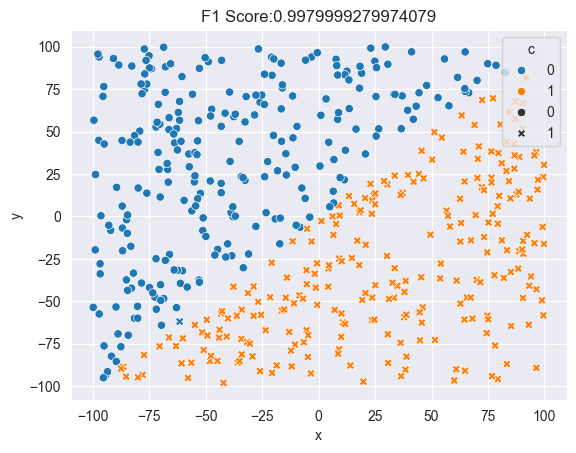

In [41]:
sns.scatterplot(x=easy_test['x'], y=easy_test['y'], hue=y_pred_test_0_v0.argmax(axis=0), style=easy_test['c'].astype(int))
score = f1_score(y_test_0, y_pred_test_0_v0.argmax(axis=0), average='macro')
plt.title(f'F1 Score:{score}')
plt.show()

## easy_softmax

In [42]:
nn_0_v1 = NeuralNetwork4(layer_sizes=[2,10,10,10,2], activation='sigmoid', output_activation='sigmoid', init_method='xavier', classification=True)

In [43]:
nn_0_v1.train(
    x_train_scaled_0,
    y_train_0,
    batch_size = 16,
    epochs = 1000,
    learning_rate=0.05,
    verbose=100,
    optimizer='basic',
)

Epoch 100/1000, Loss: 171.84615602966204
Epoch 200/1000, Loss: 41.923132351255816
Epoch 300/1000, Loss: 16.678950644550994
Epoch 400/1000, Loss: 11.259060150575998
Epoch 500/1000, Loss: 8.752924815536113
Epoch 600/1000, Loss: 7.327044631417492
Epoch 700/1000, Loss: 6.2712976428864
Epoch 800/1000, Loss: 5.543710335919773
Epoch 900/1000, Loss: 4.941972017626393
Epoch 1000/1000, Loss: 4.537546709876191
Final loss: 4.537546709876191


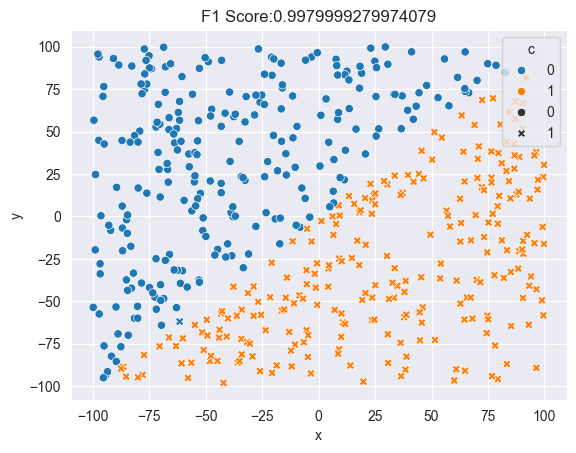

In [44]:

y_pred_test_0_v1 = nn_0_v1.forward(x_test_scaled_0)
sns.scatterplot(x=easy_test['x'], y=easy_test['y'], hue=y_pred_test_0_v1.argmax(axis=0), style=easy_test['c'].astype(int))
score = f1_score(y_test_0, y_pred_test_0_v1.argmax(axis=0), average='macro')
plt.title(f'F1 Score:{score}')
plt.show()

# rings3-regular

In [45]:
x_train_scaled_1, y_train_1, x_test_scaled_1, y_test_1 =  prepare_data_for_classification(rings3_regular_train, rings3_regular_test, target_col='c')

In [46]:
nn_1 = NeuralNetwork4(layer_sizes=[2,10,10,10,10,3], activation='sigmoid', output_activation='softmax', init_method='xavier', classification=True)

In [47]:
nn_1.train(
    x_train_scaled_1,
    y_train_1,
    batch_size = 16,
    epochs = 1000,
    learning_rate=0.05,
    verbose=100,
    optimizer='basic'
)


Epoch 100/1000, Loss: 157.29250900130685
Epoch 200/1000, Loss: 88.58383102355693
Epoch 300/1000, Loss: 76.47080518425265
Epoch 400/1000, Loss: 74.72165274636305
Epoch 500/1000, Loss: 73.40486919363444
Epoch 600/1000, Loss: 73.41454548704169
Epoch 700/1000, Loss: 87.02622039001871
Epoch 800/1000, Loss: 55.85942289919279
Epoch 900/1000, Loss: 87.00861416758515
Epoch 1000/1000, Loss: 31.66759367069324
Final loss: 31.66759367069324


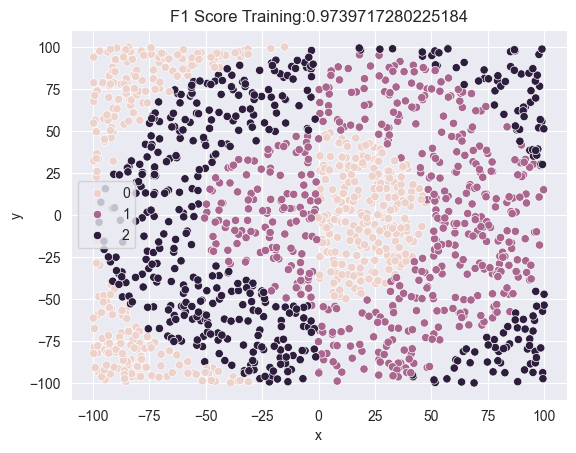

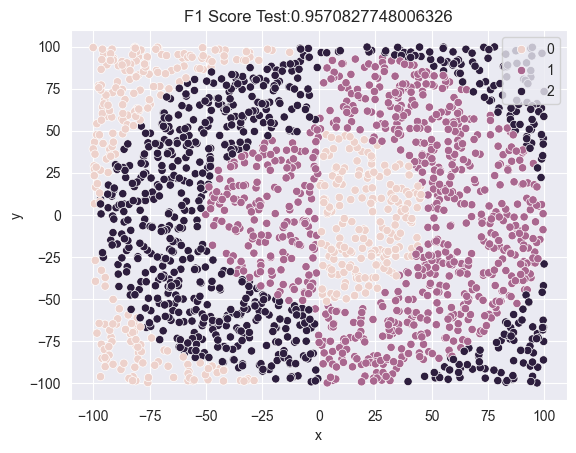

In [48]:

y_pred_train_1 = nn_1.forward(x_train_scaled_1)
sns.scatterplot(x=rings3_regular_train['x'], y=rings3_regular_train['y'], hue=y_pred_train_1.argmax(axis=0))
score = f1_score(y_train_1.argmax(axis=0), y_pred_train_1.argmax(axis=0), average='macro')
plt.title(f'F1 Score Training:{score}')
plt.show()

y_pred_test_1 = nn_1.forward(x_test_scaled_1)
sns.scatterplot(x=rings3_regular_test['x'], y=rings3_regular_test['y'], hue=y_pred_test_1.argmax(axis=0))
score = f1_score(y_test_1, y_pred_test_1.argmax(axis=0), average='macro')
plt.title(f'F1 Score Test:{score}')
plt.show()

# xor3

In [49]:
x_train_scaled_2, y_train_2, x_test_scaled_2, y_test_2 =  prepare_data_for_classification(xor3_train, xor3_test, target_col='c')

## xor3 softmax

In [50]:
nn_2_v0 = NeuralNetwork4(layer_sizes=[2,10,10,2], activation='sigmoid', output_activation='softmax', init_method='xavier', classification=True)

In [51]:
nn_2_v0.train(
    x_train_scaled_2,
    y_train_2,
    batch_size = 32,
    epochs = 10000,
    learning_rate=0.1,
    verbose=2000,
    optimizer='basic',
)




Epoch 2000/10000, Loss: 3.171420418647818
Epoch 4000/10000, Loss: 1.585030778496356
Epoch 6000/10000, Loss: 2.8962461565596893
Epoch 8000/10000, Loss: 1.7543022169063698
Epoch 10000/10000, Loss: 1.4480099500474117
Final loss: 1.4480099500474117


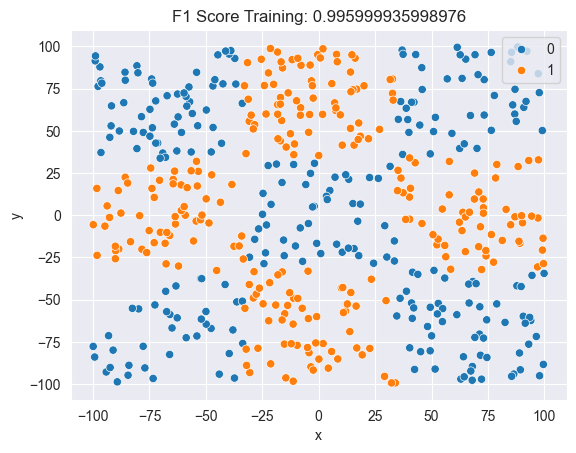

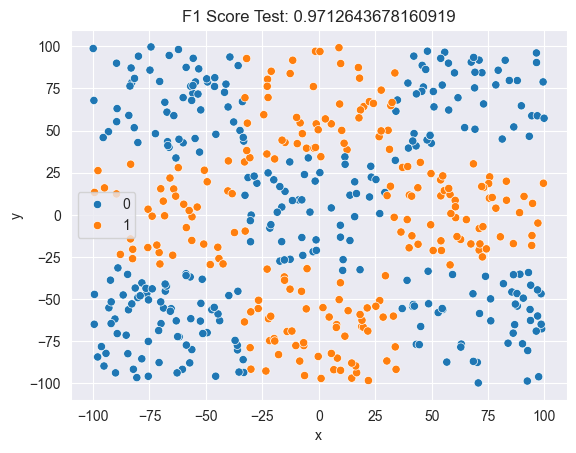

In [52]:
# Predykcje dla zbioru treningowego
y_pred_train_2_v0 = nn_2_v0.forward(x_train_scaled_2)
sns.scatterplot(x=xor3_train['x'],
                y=xor3_train['y'],
                hue=y_pred_train_2_v0.argmax(axis=0))
# Zamieniamy etykiety one-hot na indeksy dla porównania
score_train = f1_score(y_train_2.argmax(axis=0), y_pred_train_2_v0.argmax(axis=0), average='macro')
plt.title(f'F1 Score Training: {score_train}')
plt.show()

# Predykcje dla zbioru testowego
y_pred_test_2_v0 = nn_2_v0.forward(x_test_scaled_2)
sns.scatterplot(x=xor3_test['x'],
                y=xor3_test['y'],
                hue=y_pred_test_2_v0.argmax(axis=0))
score_test = f1_score(y_test_2, y_pred_test_2_v0.argmax(axis=0), average='macro')
plt.title(f'F1 Score Test: {score_test}')
plt.show()


## xor3 sigmoid

In [53]:
nn_2_v1 = NeuralNetwork4(layer_sizes=[2,10,10,2], activation='sigmoid', output_activation='sigmoid', init_method='xavier', classification=True)

In [54]:
nn_2_v1.train(
    x_train_scaled_2,
    y_train_2,
    batch_size = 32,
    epochs = 10000,
    learning_rate=0.1,
    verbose=2000,
    optimizer='basic',
)

Epoch 2000/10000, Loss: 170.1066059395987
Epoch 4000/10000, Loss: 45.46325676164369
Epoch 6000/10000, Loss: 18.40985265850639
Epoch 8000/10000, Loss: 12.459883206054428
Epoch 10000/10000, Loss: 8.787824725027374
Final loss: 8.787824725027374


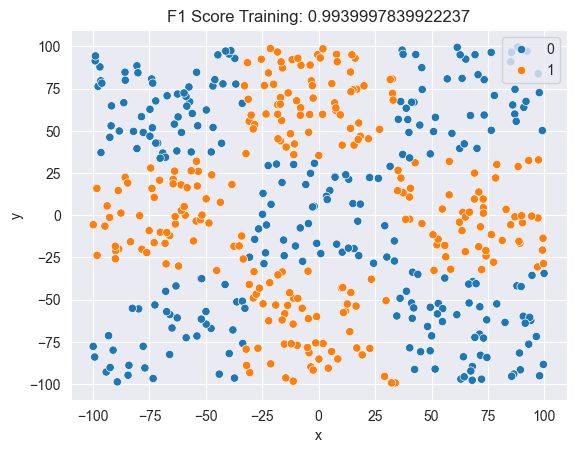

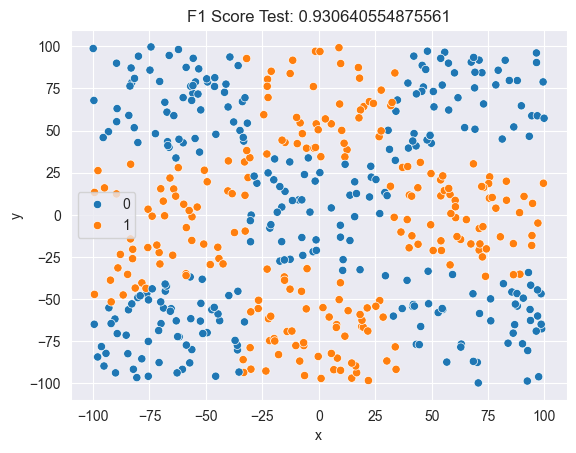

In [55]:
# Predykcje dla zbioru treningowego
y_pred_train_2_v1 = nn_2_v1.forward(x_train_scaled_2)
sns.scatterplot(x=xor3_train['x'],
                y=xor3_train['y'],
                hue=y_pred_train_2_v1.argmax(axis=0))
# Zamieniamy etykiety one-hot na indeksy dla porównania
score_train = f1_score(y_train_2.argmax(axis=0), y_pred_train_2_v1.argmax(axis=0), average='macro')
plt.title(f'F1 Score Training: {score_train}')
plt.show()

# Predykcje dla zbioru testowego
y_pred_test_2_v1 = nn_2_v1.forward(x_test_scaled_2)
sns.scatterplot(x=xor3_test['x'],
                y=xor3_test['y'],
                hue=y_pred_test_2_v1.argmax(axis=0))
score_test = f1_score(y_test_2, y_pred_test_2_v1.argmax(axis=0), average='macro')
plt.title(f'F1 Score Test: {score_test}')
plt.show()


###